In [1]:
import pandas as pd
from yahoo_fin.stock_info import get_data
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

import warnings
warnings.filterwarnings("ignore")

/Users/jasonmaytin/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
custom_tickers = [
    "^DJI",    # Dow Jones Industrial Average (DJI)
    "^GSPC",   # S&P 500
    "^IXIC",   # NASDAQ Composite
    "^FTSE",   # FTSE 100
    "^RUT",   # RUT
    "^N225",
    "^MID"
]

# Fetch data for each ticker
stock_data = {}
for ticker in custom_tickers:
    try:
        data = get_data(ticker)
        stock_data[ticker] = data
    except AssertionError as e:
        print(f"No data found for {ticker}: {e}")

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def analyze(ticker,sandp_time):

    
    def dca_analysis(sandp_time, trendline_multiplier=1.0, moving_average_windows=[20, 50], time_interval=21):
        # Convert index to datetime if it's not already in datetime format
        sandp_time.index = pd.to_datetime(sandp_time.index)

        # Function to calculate the number of shares bought with a given amount of money
        def calculate_shares(amount, price):
            return amount / price

        # Function to implement DCA strategy with variable granularity and condition
        def dca_strategy(df, investment_amount, interval, moving_averages_df, trendline_multiplier):
            shares_owned = 0  # Initial number of shares owned
            portfolio_value = []  # List to store portfolio value over time
            dates = []  # List to store dates for plotting
            investment_history = []  # List to store amount invested in each interval
            aggregated_investment = 0  # Variable to aggregate investments when condition is met

            for i in range(0, len(df), interval):
                # Get current price and moving average value
                current_price = df.iloc[i]['close']
                ma_value = moving_averages_df['Moving Average'][i]
                trendline_value = df['Trendline'][i]

                # Add aggregated investment to current DCA and reset the aggregator
                invested_period = investment_amount + aggregated_investment

                # Compare moving average to trendline
                if ma_value * trendline_multiplier < trendline_value or i>=(len(df)-interval-2):
                    # Buy shares with specified investment amount
                    shares_bought = calculate_shares(invested_period, current_price)
                    shares_owned += shares_bought

                    # Calculate the current value of shares owned
                    current_value = shares_owned * current_price
                    portfolio_value.append(current_value)
                    dates.append(df.index[i])  # Capture the date

                    # Record the amount invested in this interval
                    investment_history.append(invested_period)
                    aggregated_investment = 0 
                else:
                    # Push off the additional increment
                    current_value = shares_owned * current_price
                    portfolio_value.append(current_value)
                    dates.append(df.index[i])  # Capture the date
                    investment_history.append(0)

                    aggregated_investment += investment_amount

            return pd.DataFrame({'portfolio_value': portfolio_value, 'investment_history': investment_history}, index=dates)

        # Function to calculate moving averages
        def calculate_moving_average(df, window_size):
            return df['close'].rolling(window=window_size).mean()

        # Specify the date range interval (start_date and end_date)
        start_date = date_start
        end_date = date_end
        subset_df = sandp_time[start_date:end_date]

        # Calculate moving averages
        moving_averages_df = pd.DataFrame()
        moving_averages_df['Moving Average'] = calculate_moving_average(subset_df, moving_average_windows[0])

    #     # Generate a trendline using linear regression
    #     x_values = np.arange(len(subset_df))
    #     y_values = subset_df['close']
    #     coefficients = np.polyfit(x_values, y_values, 1)
    #     trendline = np.polyval(coefficients, x_values)
    #     subset_df['Trendline'] = trendline



        x_values = np.arange(len(subset_df))
        y_values = subset_df['close']
        # Define the exponential function
        def exponential_func(x, a, b):
            return a * np.exp(b * x)
        # Initial guess for parameters
        initial_guess = (1.0, 0.001)  # Adjust these values as needed
        # Fit the exponential curve to the data
        popt, pcov = curve_fit(exponential_func, x_values, y_values, p0=initial_guess)
        # Generate the trendline using the fitted parameters
        trendline = exponential_func(x_values, *popt)
        subset_df['Trendline'] = trendline


        # Apply DCA strategy with variable granularity and condition
        result_df = dca_strategy(subset_df, 8 * time_interval, time_interval, moving_averages_df, trendline_multiplier)

        return result_df

    # Test multiple trendline multiplier values
    multiplier_values = np.arange(0.1,2.0,0.1)  # Adjust as needed
    final_portfolio_values = []

    for multiplier in multiplier_values:
        # Call the dca_analysis function with the current multiplier
        final = dca_analysis(sandp_time, trendline_multiplier=multiplier, moving_average_windows=[100, 50], time_interval=21)
        # Append the final portfolio value to the list
        final_portfolio_values.append(final["portfolio_value"][-1])

    # Combine the multiplier values and final portfolio values into a list of tuples
    result_tuples = list(zip(multiplier_values, final_portfolio_values))

    # Sort the list of tuples based on final portfolio values in descending order
    result_tuples.sort(key=lambda x: x[1], reverse=True)

    # Print the top 5 results
    #print("Top 5 Trendline Multipliers and Final Portfolio Values:")
    #for index, (multiplier, final_value) in enumerate(result_tuples[:5], start=1):
    #    print(f"Rank {index}: Trendline Multiplier: {multiplier}, Final Portfolio Value: {final_value}")
    #plt.plot(multiplier_values,final_portfolio_values)
    optimal_value = result_tuples[0][0]

    def dca_analysis(sandp_time, trendline_multiplier=1.0, moving_average_windows=[20, 50], time_interval=21):
        # Convert index to datetime if it's not already in datetime format
        sandp_time.index = pd.to_datetime(sandp_time.index)

        # Function to calculate the number of shares bought with a given amount of money
        def calculate_shares(amount, price):
            return amount / price

        # Function to implement DCA strategy with variable granularity and condition
        def dca_strategy(df, investment_amount, interval, moving_averages_df, trendline_multiplier):
            shares_owned = 0  # Initial number of shares owned
            portfolio_value = []  # List to store portfolio value over time
            dates = []  # List to store dates for plotting
            investment_history = []  # List to store amount invested in each interval
            aggregated_investment = 0  # Variable to aggregate investments when condition is met

            for i in range(0, len(df), interval):
                # Get current price and moving average value
                current_price = df.iloc[i]['close']
                ma_value = moving_averages_df['Moving Average'][i]
                trendline_value = df['Trendline'][i]

                # Add aggregated investment to current DCA and reset the aggregator
                invested_period = investment_amount + aggregated_investment

                # Compare moving average to trendline
                if ma_value * trendline_multiplier < trendline_value or i>=(len(df)-interval-2):
                    # Buy shares with specified investment amount
                    shares_bought = calculate_shares(invested_period, current_price)
                    shares_owned += shares_bought

                    # Calculate the current value of shares owned
                    current_value = shares_owned * current_price
                    portfolio_value.append(current_value)
                    dates.append(df.index[i])  # Capture the date

                    # Record the amount invested in this interval
                    investment_history.append(invested_period)
                    aggregated_investment = 0 
                else:
                    # Push off the additional increment
                    current_value = shares_owned * current_price
                    portfolio_value.append(current_value)
                    dates.append(df.index[i])  # Capture the date
                    investment_history.append(0)

                    aggregated_investment += investment_amount

            return pd.DataFrame({'portfolio_value': portfolio_value, 'investment_history': investment_history}, index=dates)

        # Function to calculate moving averages
        def calculate_moving_average(df, window_size):
            return df['close'].rolling(window=window_size).mean()

        # Specify the date range interval (start_date and end_date)
        start_date = date_start
        end_date = date_end
        subset_df = sandp_time[start_date:end_date]

        # Calculate moving averages
        moving_averages_df = pd.DataFrame()
        moving_averages_df['Moving Average'] = calculate_moving_average(subset_df, moving_average_windows[0])

        def exponential_func(x, a, b, c):
            return a * np.exp(b * x) + c

        # Generate a trendline using linear regression
    #     x_values = np.arange(len(subset_df))
    #     y_values = subset_df['close']
    #     coefficients = np.polyfit(x_values, y_values, 1)
    #     trendline = np.polyval(coefficients, x_values)
    #     subset_df['Trendline'] = trendline




        x_values = np.arange(len(subset_df))
        y_values = subset_df['close']
        # Define the exponential function
        def exponential_func(x, a, b):
            return a * np.exp(b * x)
        # Initial guess for parameters
        initial_guess = (1.0, 0.001)  # Adjust these values as needed
        # Fit the exponential curve to the data
        popt, pcov = curve_fit(exponential_func, x_values, y_values, p0=initial_guess)
        # Generate the trendline using the fitted parameters
        trendline = exponential_func(x_values, *popt)
        subset_df['Trendline'] = trendline



        a, b = popt
        exponential_growth_rate = b * 100
        

        # Apply DCA strategy with variable granularity and condition
        result_df = dca_strategy(subset_df, 8 * time_interval, time_interval, moving_averages_df, trendline_multiplier)

        # Plot moving averages and S&P levels
        plt.figure(figsize=(10, 6))
        plt.plot(subset_df.index, moving_averages_df['Moving Average'], color='red', label='Moving Average')
        plt.plot(subset_df.index, subset_df['Trendline'], color='green', label='Trendline')
        plt.plot(subset_df.index, subset_df['close'], color='blue', label='S&P Close')
        for date in result_df.index[result_df['investment_history'] > 0]:
            plt.axvline(x=date, color='gray', linestyle='--', linewidth=0.5)
        plt.title('Moving Average and Trendline vs. S&P Levels Over Time')
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.legend()
        plt.show()
        
        #print("Percent Return: " + str(round(100*(moving_averages_df['Moving Average'][-1]-moving_averages_df['Moving Average'].dropna()[0])/moving_averages_df['Moving Average'].dropna()[0],2)))

        # Calculate the total return over the period
        first_price = subset_df['close'].iloc[:20].mean()
        last_price = subset_df['close'].iloc[-20:].mean()

        # Calculate total return
        total_return = last_price / first_price

        # Calculate the number of years in the period
        num_years = len(subset_df) / 252

        # Calculate the annualized average return
        annualized_return = (total_return ** (1 / num_years)) - 1

        
        
        #print("Exponential Growth Rate: {:.2f}".format(exponential_growth_rate))
        print("Annualized Return: {:.4f}%".format(annualized_return*100))
        
#         plt.figure(figsize=(10, 6))
#         plt.plot(result_df.index.strftime('%Y-%m-%d'), result_df['portfolio_value'], color='blue', label='Portfolio Value')
#         plt.title('Portfolio Value Over Time')
#         plt.xlabel('Date')
#         plt.ylabel('Portfolio Value')
#         plt.xticks(rotation=45)
#         plt.legend(loc='upper left')
#         plt.show()

#         # Plot individual investments
#         plt.figure(figsize=(10, 6))
#         plt.bar(result_df.index.strftime('%Y-%m-%d'), result_df['investment_history'], color='orange', label='Individual Investments')
#         plt.title('Individual Investments Over Time')
#         plt.xlabel('Date')
#         plt.ylabel('Individual Investments')
#         plt.xticks(rotation=45)
#         plt.legend(loc='upper left')
#         plt.show()

        return result_df, annualized_return

    final, annual_return = dca_analysis(sandp_time, trendline_multiplier=1.0, moving_average_windows=[100, 50], time_interval=21)
    return annual_return
    #print(final["portfolio_value"][-1])

^GSPC: 1980-01-01 to 1984-12-31:


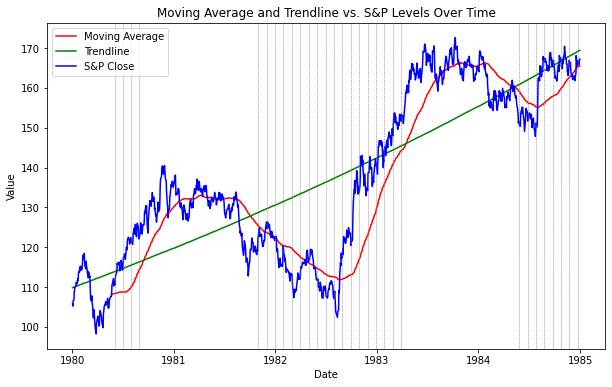

Annualized Return: 8.2490%


^GSPC: 1984-01-01 to 1988-12-31:


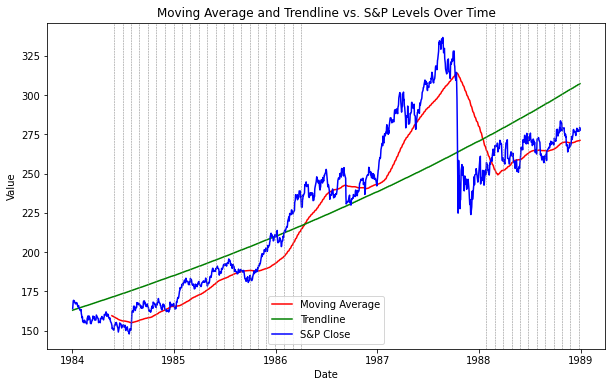

Annualized Return: 10.6528%


^GSPC: 1988-01-01 to 1992-12-31:


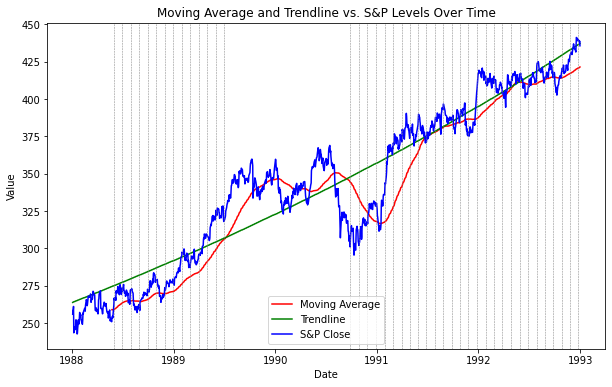

Annualized Return: 11.6831%


^GSPC: 1992-01-01 to 1996-12-31:


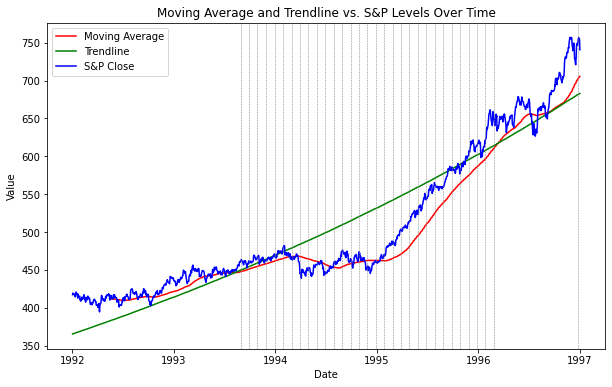

Annualized Return: 12.2002%


^GSPC: 1996-01-01 to 2000-12-31:


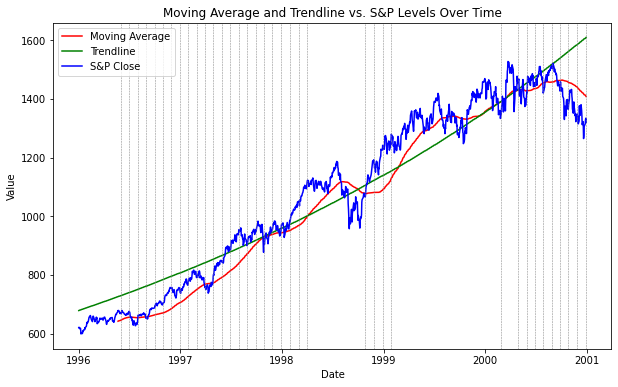

Annualized Return: 16.7460%


^GSPC: 2000-01-01 to 2004-12-31:


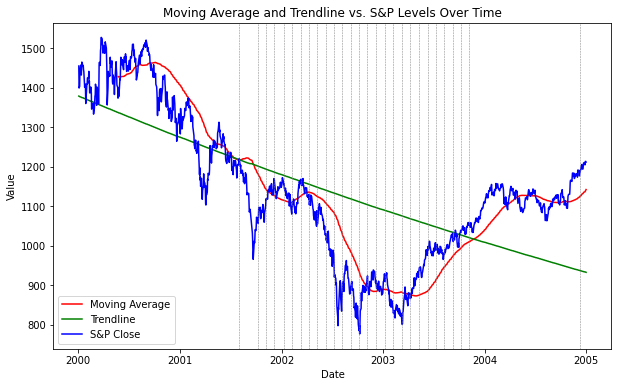

Annualized Return: -3.3964%


^GSPC: 2004-01-01 to 2008-12-31:


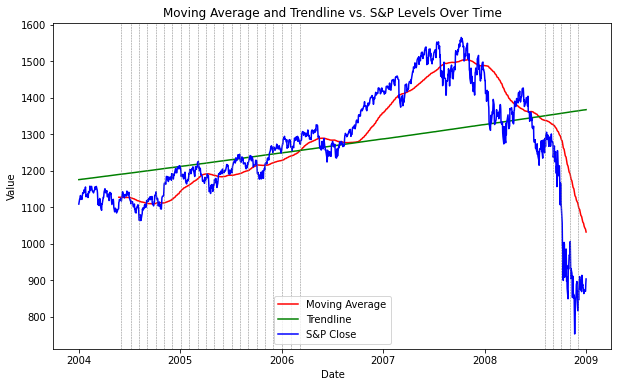

Annualized Return: -4.8795%


^GSPC: 2008-01-01 to 2012-12-31:


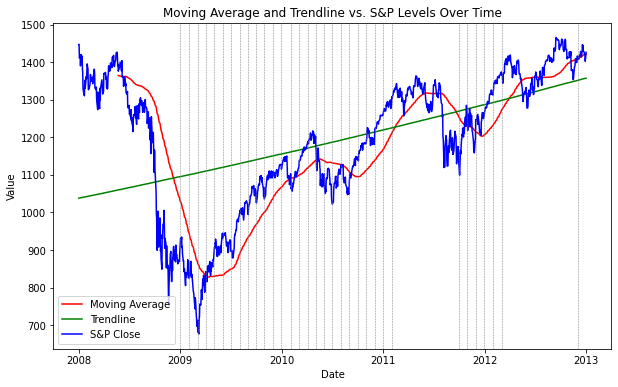

Annualized Return: 0.6238%


^GSPC: 2012-01-01 to 2016-12-31:


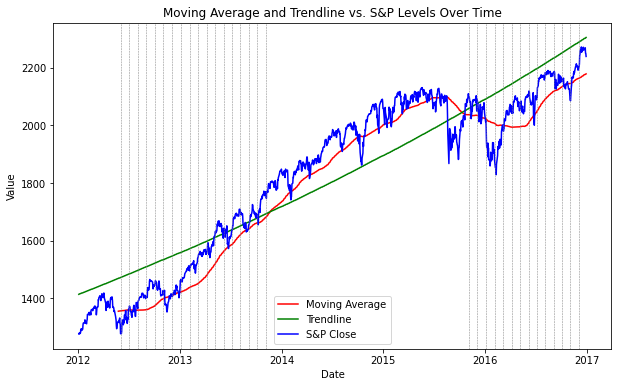

Annualized Return: 11.5994%


^GSPC: 2016-01-01 to 2020-12-31:


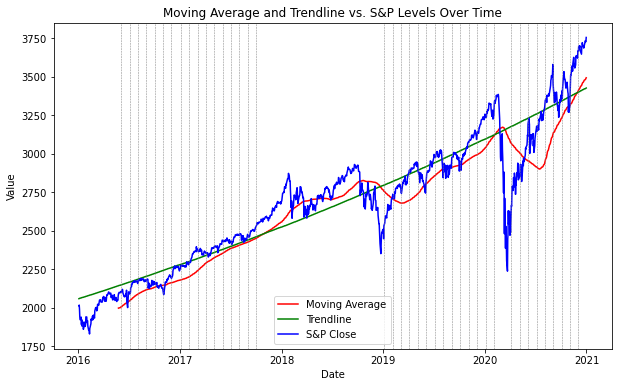

Annualized Return: 14.0253%


^GSPC: 2020-01-01 to 2024-12-31:


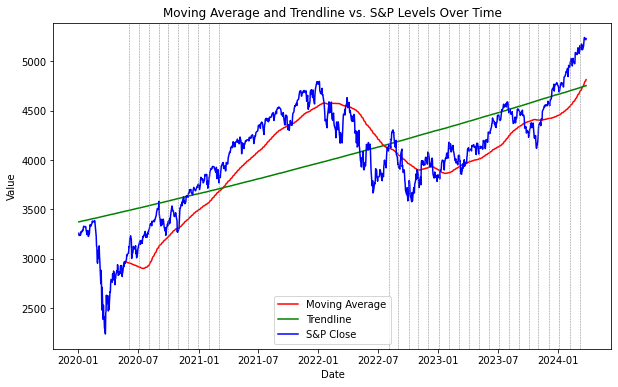

Annualized Return: 11.2848%




In [48]:
custom_tickers = [
    "^DJI",    # Dow Jones Industrial Average (DJI)
    "^GSPC",   # S&P 500
    "^IXIC",   # NASDAQ Composite
    "^FTSE",   # FTSE 100
    "^RUT",   # RUT
    "^N225",
    "^MID"
]

annual_returns = []
ticker = "^GSPC"

start_year = 1980

interval = 4

for year in range(start_year, 2024, interval):
    date_start = f"{year}-01-01"
    date_end = f"{year+interval}-12-31"  # Increment by 10 years
    for i in [ticker]:
        sandp = stock_data[i].dropna()  # Assuming stock_data is defined elsewhere
        print(f"{i}: {date_start} to {date_end}:")
        annual_return =analyze(i, sandp)
        annual_returns.append(annual_return)
        print()
        print()

Average Annual Returns: 8.071686620610013


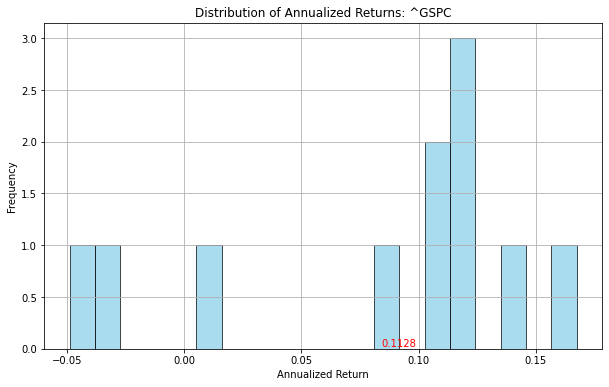

In [49]:
plt.figure(figsize=(10, 6))
hist, bins, _ = plt.hist(annual_returns, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.title(f'Distribution of Annualized Returns: {ticker}')
plt.xlabel('Annualized Return')
plt.ylabel('Frequency')
plt.grid(True)

# Find the index of the bin where the last value in annual_returns falls
last_value_index = np.searchsorted(bins, annual_returns[-1], side='right') - 1

# Labeling the specific bar with the last value in annual_returns and color it differently
plt.text(bins[last_value_index-1], hist[last_value_index-1], f'{annual_returns[-1]:.4f}', ha='center', va='bottom', color='red')

# Change the color of the specific bar
plt.bar(bins[last_value_index-1], hist[last_value_index-1], width=bins[last_value_index-1] - bins[last_value_index], color='red', edgecolor='black', alpha=0.7)
print("Average Annual Returns: " + str(np.mean(annual_returns)*100))

Average Annual Returns: 8.391723154930391


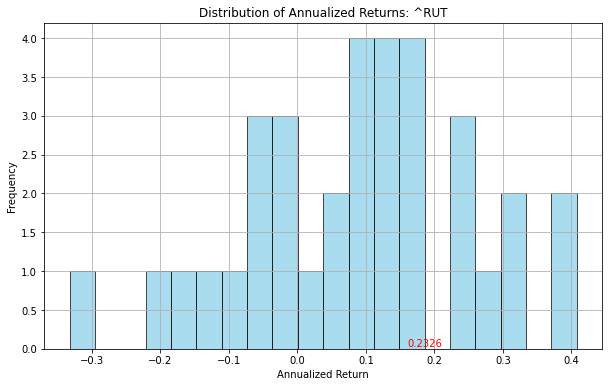

In [237]:
import os

# Create the plots folder if it doesn't exist
if not os.path.exists("plots"):
    os.makedirs("plots")

plt.figure(figsize=(10, 6))
hist, bins, _ = plt.hist(annual_returns, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.title(f'Distribution of Annualized Returns: {ticker}')
plt.xlabel('Annualized Return')
plt.ylabel('Frequency')
plt.grid(True)

# Find the index of the bin where the last value in annual_returns falls
last_value_index = np.searchsorted(bins, annual_returns[-1], side='right') - 1

# Labeling the specific bar with the last value in annual_returns and color it differently
plt.text(bins[last_value_index-1], hist[last_value_index-1], f'{annual_returns[-1]:.4f}', ha='center', va='bottom', color='red')

# Change the color of the specific bar
plt.bar(bins[last_value_index-1], hist[last_value_index-1], width=bins[last_value_index-1] - bins[last_value_index], color='red', edgecolor='black', alpha=0.7)

print("Average Annual Returns: " + str(np.mean(annual_returns)*100))
plt.savefig(f"plots/annual_returns_{ticker}.png")

In [ ]:
#DJI = 8.27%
#GSPC (SANP) = 9.21%
#MID = 10.42%
#NASDAQ = 11.27%
#RUT = 8.39%